### Goal: the goal is to write a software pipeline to identify vehicles in a video from a front-facing camera on a car. 

#### Histogram of Oriented Gradients (HOG). Explain how (and identify where in your code) you extracted HOG features from the training images. Explain how you settled on your final choice of HOG parameters.

The HOG parameters were discovered primarily through trial and error by iterating through sets of colour space, oritations, pixels per cells etc. The accuracy was pretty much similar  - in the region of 97 to 99% percent. Using only the Value channel of the HSV color space, I was able to use only the single channel (Value) which sped up the detection, however during the detection it was not as satisfactory as using all 3 colour channels. The final parameters chosen can be found in  globals.py and uses the RGB colour space. The spatial and colour histogram features did not seem to have much influence over the quality of detections and I could have dropped these from the final detection runs.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import globals as g
from features import *
from utils import *
from utils2 import *
from heatmap import *


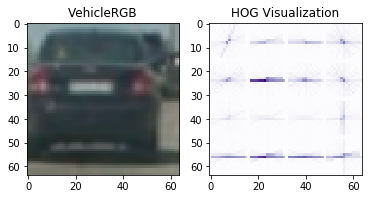

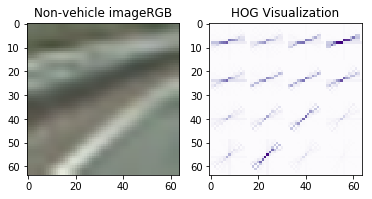

In [2]:
hog_params = g.HOG_RGB #load HSV dictionary 

# plot the hog image for a vehicle returned with vis set to true
img = mpimg.imread('examples/vehicle.png')
features, hog_img = get_hog_features(img[:,:,2],hog_params['hog_orient'], hog_params['hog_pix_per_cell'], hog_params['hog_cell_per_block'], vis=True, feature_vec=True)
hog_visualise(img, hog_img, title="Vehicle"+hog_params['color_space'], save=True)

# plot the hog image for a non-vehg.icle returned with vis set to true
img = mpimg.imread('examples/non_vehicle.png')
features, hog_img = get_hog_features(img[:,:,2],hog_params['hog_orient'], hog_params['hog_pix_per_cell'], hog_params['hog_cell_per_block'], vis=True, feature_vec=True)
hog_visualise(img, hog_img, title="Non-vehicle image"+hog_params['color_space'], save=True)

##### Include which color space was chosen and why. Include which HOG parameters (orientations, pixels_per_cell, cells_per_block) were chosen and why.

Some of the HOG tuning parameter spaces are defined in the globals.py file. You can choose from one of 3 parameters for feature extraction HOG_HSV< HOG_LUV, HOG_RGB. The output of the hog features resulting from these 3 parameter spaces is shown below. As one can see, it is a difficult choice, but I chose to use the RGB parameter space to proceed with the classifier training in the final model.

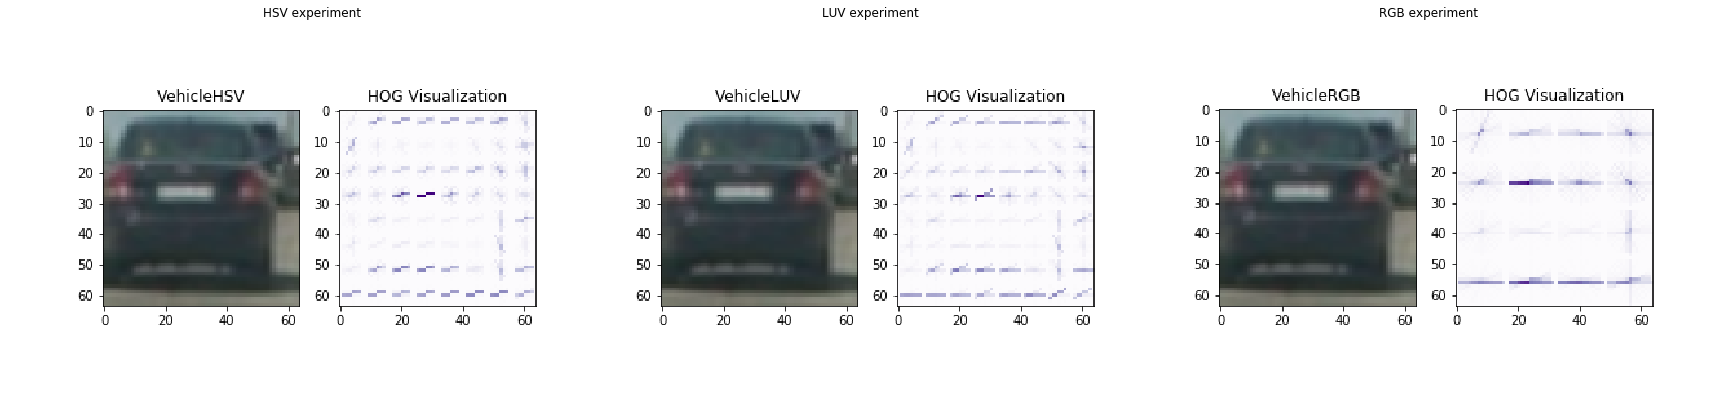

In [3]:
hog_img_paths = glob.glob('./output_images/Vehicle*HOG.png')
hog_images = [imread(img) for img in hog_img_paths]

import matplotlib.gridspec as gridspec
    
show_images(hog_images, titles = ["HSV experiment","LUV experiment","RGB experiment"], output_file = "output_images/" + "Test_sliding_96_128.png", rows = 1, cols = 3)



#### Explain how (and identify where in your code) you extracted HOG features from the training images.

The training set is loaded using the load_training_set function in utils.py. The HOG features are extracted in the extract_img_features function which is then used by the extract_features function that generates the features for the training set arrays of vehicles and non-vehicle images. The HOG features are extracted per channel and aggregated depending on the hog_channel setting in  globals.py.


In [4]:

# Extract HOG features per channel
def extract_hog_features(img):
    if hog_params['hog_channel'] == 'ALL':
        hog_features = []
        for channel in range(img.shape[2]):
            hog_features.append(get_hog_features(img[:,:,channel],hog_params['hog_orient'], hog_params['hog_pix_per_cell'], hog_params['hog_cell_per_block'], vis=False, feature_vec=False))
        return np.array(hog_features)
    else:
        hog_features = get_hog_features(img[:,:,hog_params['hog_channel']],hog_params['hog_orient'], hog_params['hog_pix_per_cell'], hog_params['hog_cell_per_block'], vis=False, feature_vec=False)        
        return hog_features


# Define a function to extract features from a single image window
def extract_img_features(img):
    img_features = []
    feature_image = np.copy(img)
    feature_image = RGB_to_color_space(img, hog_params['color_space'])
   
    if g.spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=g.hog_spatial_size)
        img_features.append(spatial_features)
    
    if g.hist_feat == True:
        hist_features = color_hist(feature_image, nbins=g.hog_hist_bins)
        img_features.append(hist_features)
    
    if g.hog_feat == True:
        hog_features = extract_hog_features(img)
        img_features.append(np.ravel(hog_features))
        
    return np.concatenate(img_features)


# Define a function to extract features from a list of images
def extract_features(imgs):
    features = []
    for img in imgs:
        image_features = extract_img_features(img)
        features.append(image_features)
    return features

#load the training set
print("Loading vehicle and non-vehicle images ...")
vehicle_imgs, nonvehicle_imgs = load_training_set()
print("vehicle count : {0}".format(len(vehicle_imgs)))
print("non vehicle count : {0} ".format(len(nonvehicle_imgs)))
print("...loading training set done")

#extract features
print("Extracting features...")
vehicles_features = extract_features(vehicle_imgs)
nonvehicles_features =  extract_features(nonvehicle_imgs)
print("... Feature extraction done")


Loading vehicle and non-vehicle images ...
vehicle count : 8792
non vehicle count : 8968 
...loading training set done
Extracting features...
... Feature extraction done


#### Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

The extracted features (spatial, color histogram and HOG) are then used to train a SVM classifier in train function in the utils.py. The training set is generated by stacking vehicle and non-vehicle features and is then split into a 80/20 training/test set before fitting and used to validate the accuracy of the SVM classification.
The model are tagged with the color space and accuracy and saved for the next the nextep of vehicle detection in images and video frames.

In [5]:

#training
print("Training classifier...")
clf, scaler, accuracy = train(vehicles_features, nonvehicles_features)
print("... Training done")
print("Accuracy: ", np.round(accuracy, 4))



Training classifier...
... Training done
Accuracy:  0.9865


In [6]:
#Save the models with experiment tags 
print ("Saving models...")
title = hog_params['color_space']
save_model(clf, scaler, hog_params, title +'_' + str(np.round(accuracy, 4)) )
print("... Models saved")

Saving models...
... Models saved


In [7]:
f1 = extract_img_features(vehicle_imgs[rand.randint(0, 1000)])
f2 = extract_img_features(nonvehicle_imgs[rand.randint(0, 1000)])

f = scaler.transform([f1, f2])
print(clf.predict(f))


[ 1.  0.]


In [8]:
print ("Loading models...")

#model = joblib.load('model_LUV_0.9797.pkl')
model = joblib.load('model_RGB_0.9865.pkl')
clf = model['clf']
scaler = model['scaler']
hog_params = model['hog_params']
print("...Models loaded")

Loading models...
...Models loaded


In [9]:
f1 = extract_img_features(vehicle_imgs[rand.randint(0, 1000)])
f2 = extract_img_features(nonvehicle_imgs[rand.randint(0, 1000)])

f = scaler.transform([f1, f2])
print(clf.predict(f))


[ 1.  0.]


#### Sliding window search
Describe how (and identify where in your code) you implemented a sliding window search.
How did you decide what scales to search and how much to overlap windows?
Give Some justification for the particular implementation chosen.

The sliding window code is listed below. The window slice is calculated from pairs of xy_start (start location of window) and   (limiter for sliding windows)  arrays  which are iteratively incremented along the height and width of the window by a predetermined overlap factor. The sliding dow paramenters are defined in globals.py. The sliding widow generator is used by the get_hot_windows function to predict a vehicle or non-vehicle presence in the window patch.

In [10]:
import time
from scipy.ndimage.measurements import label

def sliding_window(img, overlap=0.75, windowSizes=[96], xy_start=[(400,400)], xy_stop=[(1240,600)] ):
    for i,m in enumerate(windowSizes):
        stepSize = int(m*(1-overlap))
        for y in range(xy_start[i][1], xy_stop[i][1], stepSize):
            for x in range(xy_start[i][0], xy_stop[i][0], stepSize):
                # yield the next window      
                yield (x, y), (x+m, y+m)
                
def get_hot_windows(img, clf, scaler, overlap=0.75, windowSizes=[96], xy_start=[(400,400)], xy_stop=[(1240,600)] ,win_limit=(1280,720)):
    hot_windows = []
    #hog_features = extract_hog_features(img)
    for (x_ll, y_ll), (x_ur,y_ur) in sliding_window(img,overlap, windowSizes, xy_start, xy_stop):
        # if the window is not within limits, ignore it
        if ( y_ur >= win_limit[1]) or ( x_ur >= win_limit[0]):
            continue
 
        test_img = img[y_ll:y_ur,x_ll:x_ur,:]
        test_img = cv2.resize(test_img, (64, 64))
        #hog_offset = (x_ll // hog_params['hog_pix_per_cell'], y_ll // hog_params['hog_pix_per_cell'])
        #hog_width = (test_img.shape[1] // hog_params['hog_pix_per_cell']) - 1
        #features = extract_img_features(test_img,hog_features=hog_features[:, hog_offset[1]:hog_offset[1] + hog_width, hog_offset[0]:hog_offset[0] + hog_width, :, :, :])
        features = extract_img_features(test_img)
        test_features = scaler.transform(features.reshape(1, -1))
        if clf.predict(test_features) ==1:
            caridx = clf.decision_function(test_features)
            if caridx > 0.5:
                hot_windows.append([(x_ll,y_ll),(x_ur,y_ur)]) 
    return hot_windows




#### How did you decide what scales to search and how much to overlap windows? Give Some justification for the particular implementation chosen. 

Experiementation with different window sizes and start/stop position and plotting the results of the hot windows helped determine the balance point between detecting vehicle, reducing false positives and  avoiding increased processing time because of too many sliding windows. The more granualar window patches resulted in  false positives and also increased window interations. The larger window sizes improved processing time but failed to detect vehicles as they moved away into the horizon.

I also expereimented with different scales and scan topologies. Eventually, a perimenter scan provided the most satifactory result. This allows for larger window scales in the near vision area and smaller window scales in the distant vision areas. This sliding window topology is illustrated below along with the results of the hot window search.

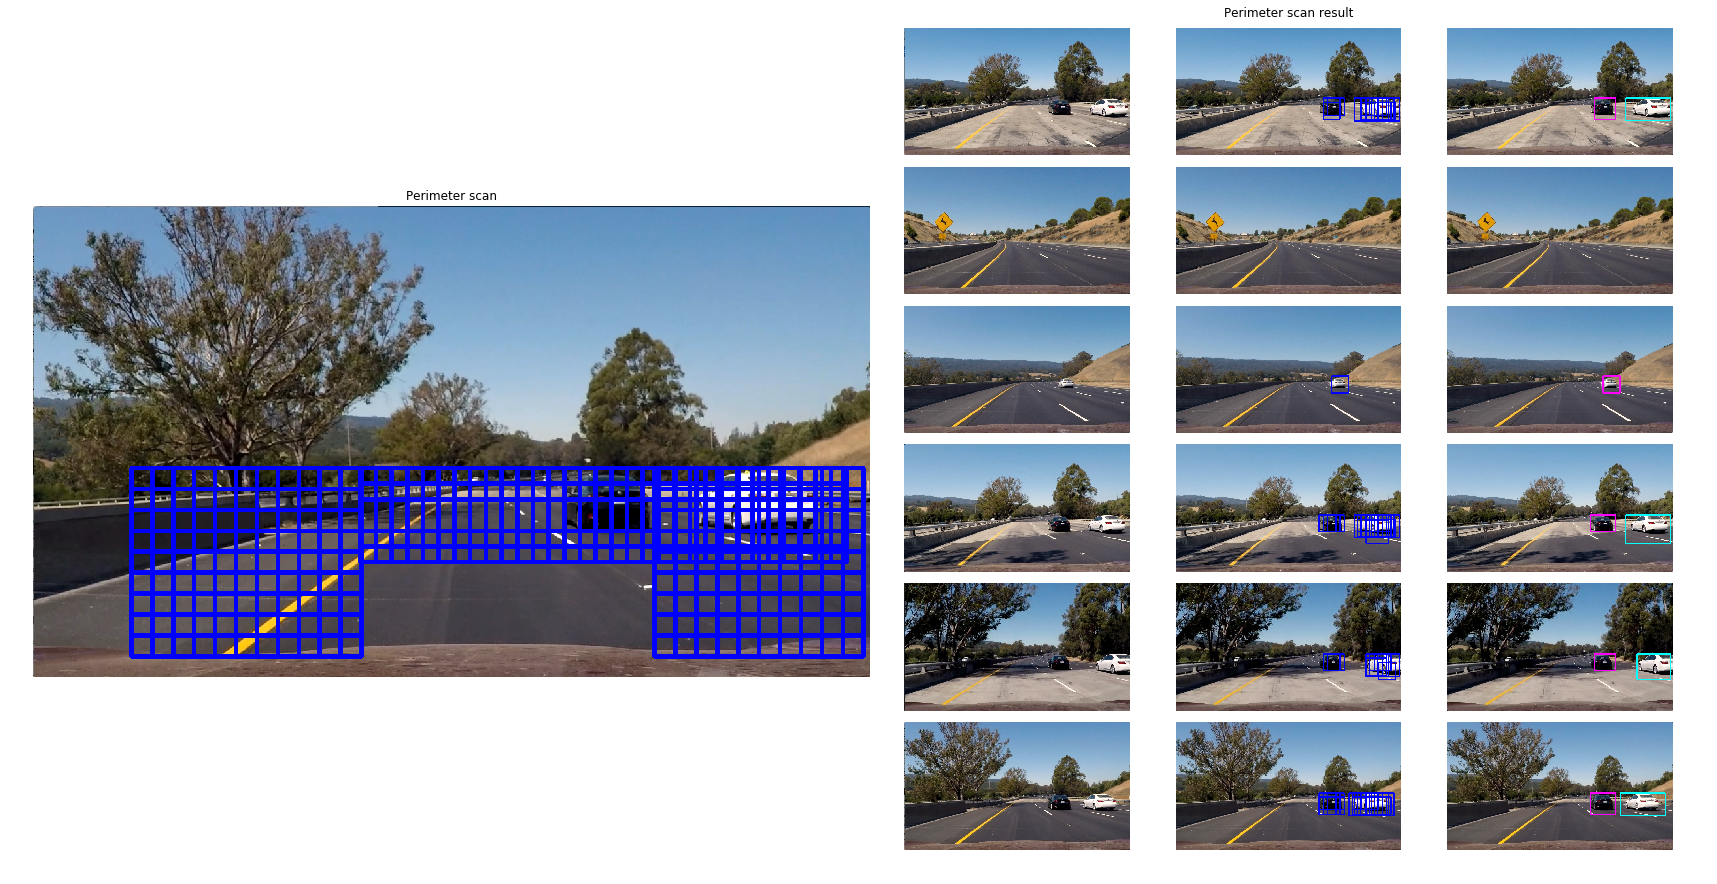

In [11]:
paths_128_96_128 = glob.glob('./output_images/*_128_96_128.png')
imgs_128_96_128 = [imread(img) for img in paths_128_96_128]
show_images(imgs_128_96_128, titles = ["Perimeter scan","Perimeter scan result"], rows = 1, cols = 2)



#### Show some examples of test images to demonstrate how your pipeline is working.
Although above result delivered satifactory results, the left side scan was stripped in the final model to reduce processing time (although I suspect it may be needed for the processing pipeline to work in alternative road topologies and car position where the vehicles appear on the left side instead of only from the right side in the test video). 

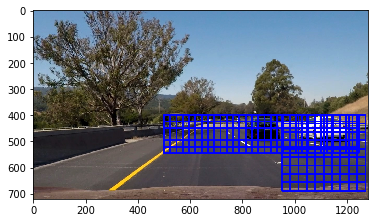

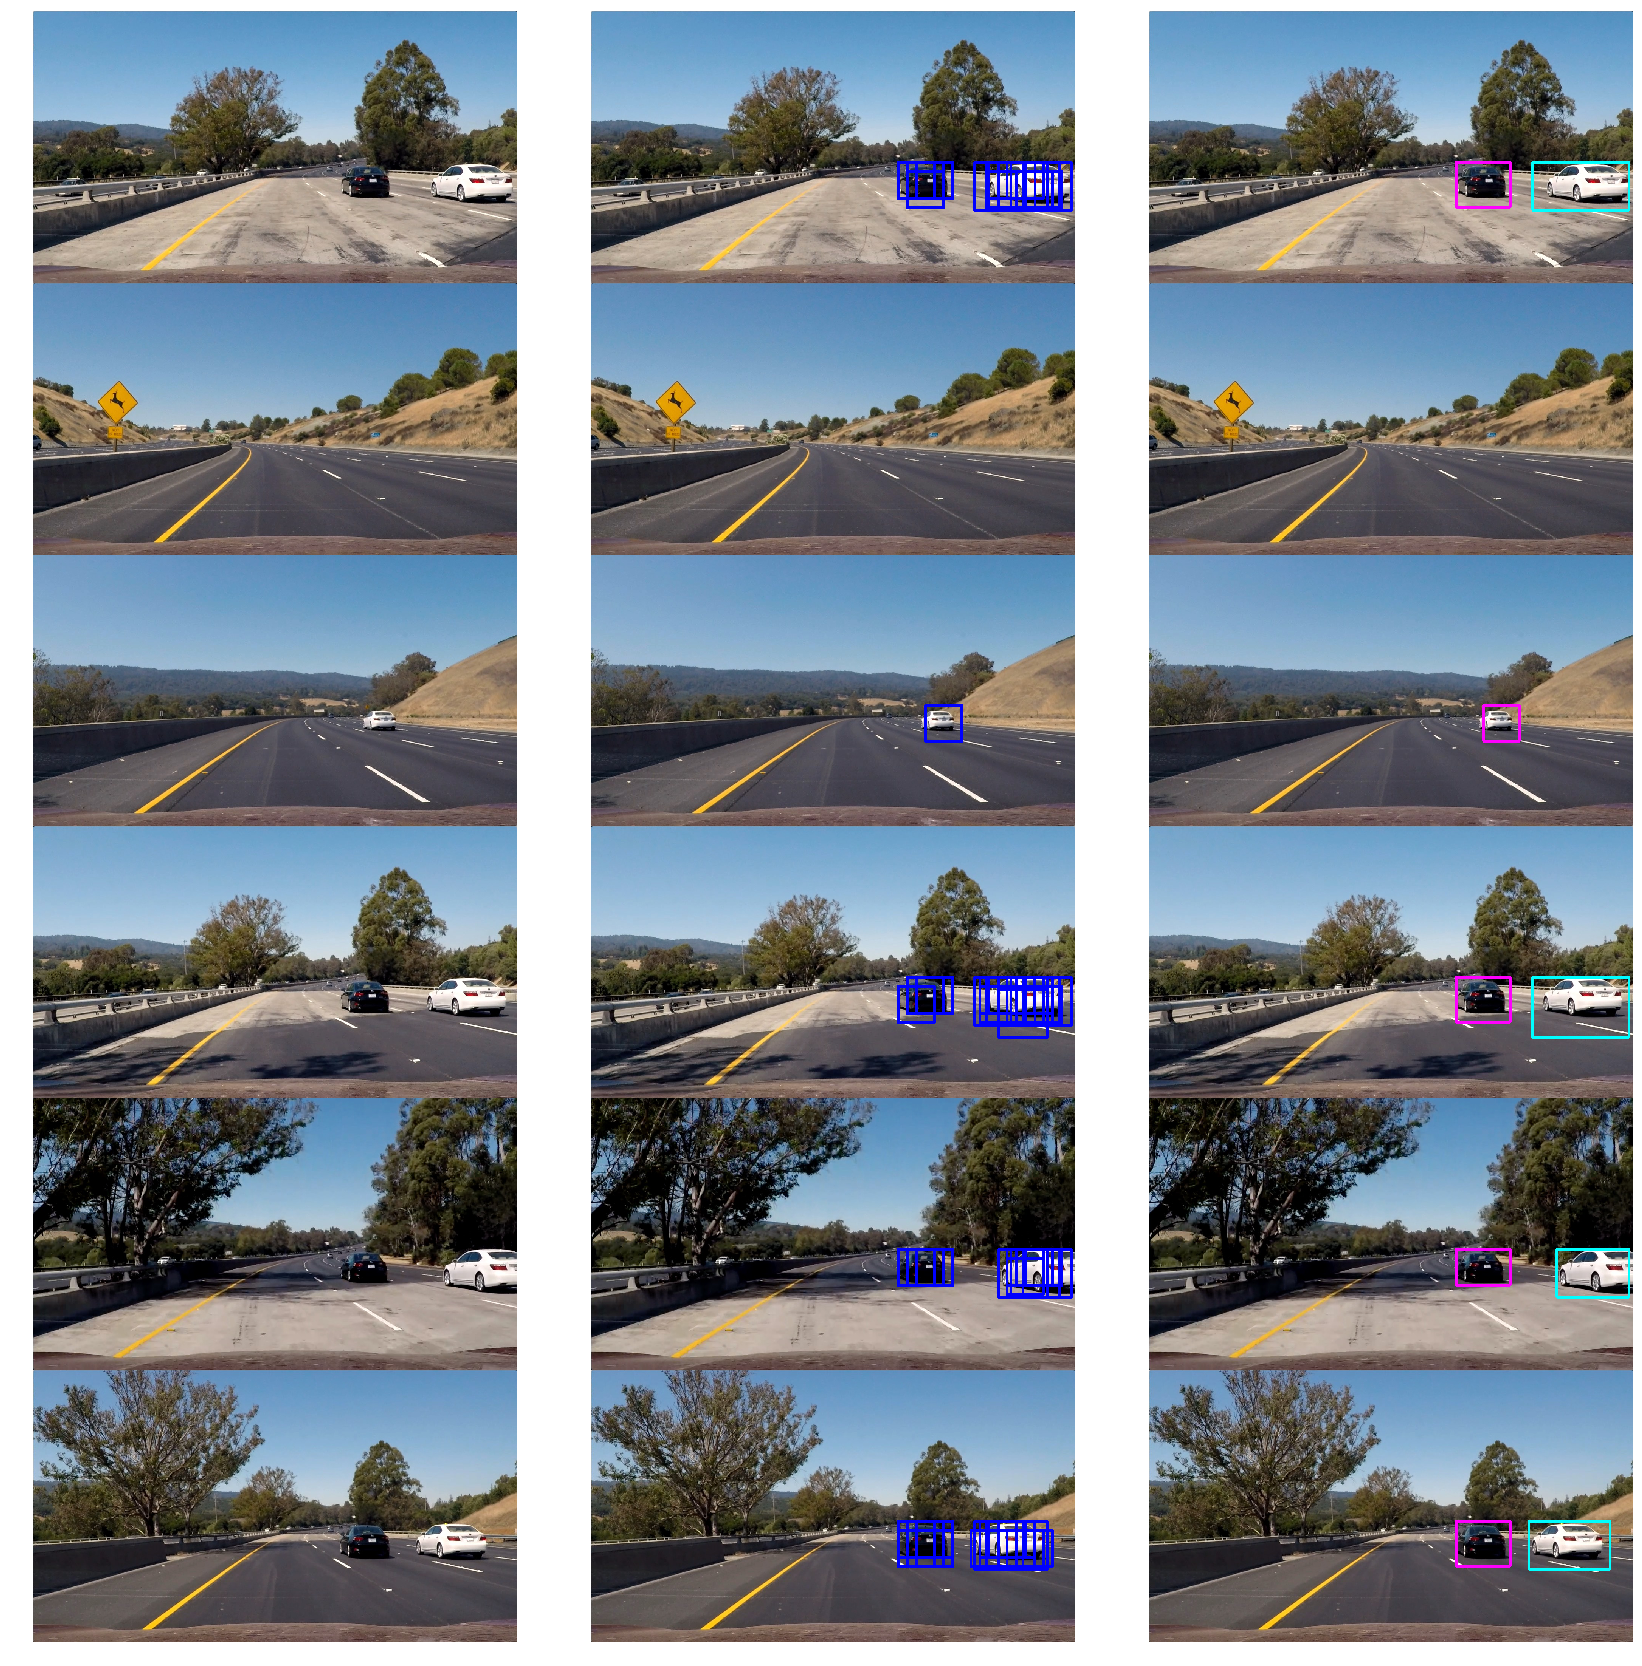

In [12]:
patch_96_128 = imread('./output_images/patches_96_128.png')
plt.imshow(patch_96_128)
plt.show()

output_imgs = []
test_img_paths = glob.glob('./test_images/*.*')
test_images = [imread(img) for img in test_img_paths]
for img in test_images:
    draw_image = np.copy(img)
    output_imgs.append(img)
    
    heatmapper = Heatmapper(g.memory)
    hot_windows = get_hot_windows(img,clf, scaler,g.overlap, g.windowSizes, g.xy_start, g.xy_stop)
    #plt.imsave("output_images/patches_96_128.png",img_h)
    heatmapper.update(hot_windows)
    heatmap = heatmapper.get_heatmap(img)
    heatmap = np.clip(heatmap , 0, 255)
    img_h = draw_boxes(draw_image,hot_windows)
    output_imgs.append(img_h)
    labels = label(heatmap)
    img_l = draw_labeled_bboxes(draw_image, labels)
    output_imgs.append(img_l)
    
show_images(output_imgs, rows = 6, cols = 3, output_file = "output_images/" + "Test_sliding_96_128.png")


#### How did you optimize the performance of your classifier? Give some discussion around how you improved the reliability of the classifier i.e., fewer false positives and more reliable car detections (this could be things like choice of feature vector, thresholding the decision function, hard negative mining etc.)

Although the processing pipeline delivered satisfactory results on the test images, it did throw up some false positive when processing the project video. To filter out the false positives, I adopted 3 strategies:
1. Implemented a heat map queue wich stored the heatmap from hot window searches in each frame. Different queue sizes were tried but the more history resulted in smoother heat map profiles. A threshold of 2-3 hits more than the menory was set to retain more persitent detection such as those from the vehicles.
2. Plotting the area of heatmap boxes (after aggregation using the scipy.measurements.label function) to determine the minimum area profile of the vehicle and using this as a threshold to filter out smaller detections such as those from lane patches with dark shadows which sometimes result in a false positive. This area threshold was set to 6400 sq. pixels
3. Using a final decision function from the svm clasifier to detemine a car index to filter out less likely 'car' objects. this was determine through objervation to be around 0.5.

#### Video Implementation.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

In [13]:
from moviepy.video.io.VideoFileClip import VideoFileClip

def process_image(img):
    draw_image = np.copy(img)
    hot_windows = get_hot_windows(img,clf, scaler,g.overlap, g.windowSizes, g.xy_start, g.xy_stop)
    heatmapper.update(hot_windows)
    heatmap = heatmapper.get_heatmap(img)
    heatmap = heatmapper.apply_threshold(heatmap,g.memory+3) #guestimation based on 75% overlap
    labels = label(heatmap)
    return draw_labeled_bboxes(draw_image, labels)

heatmapper = Heatmapper(g.memory)
white_output = 'project_video_test' + hog_params['color_space'] + '.mp4'
clip = VideoFileClip('./project_video.mp4')
white_clip = clip.fl_image(process_image)
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_testRGB.mp4
[MoviePy] Writing video project_video_testRGB.mp4


100%|█████████▉| 1260/1261 [10:32<00:00,  2.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_testRGB.mp4 



#### Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

I used a heatmap queue implementation with thresholding to filter out false positive (see heatmap.py) along with min area filtering and the classifier decision function threshold. See classifier performance eplaination above for further details. I used the scipy.meeasurement.label function to identify connected heat regions using a integer label. Each returned label identifies a car blob which is then highligted using a bounding box rectangle with its own colour. The colour identification is not perfect as the labels based on region blobs and the blobs lose their identity when one vehicle overlaps or occludes the other.

#### Provide a link to your final video output.
The video output from the pipeline combined with the pipeline from the advance lane detection is shown below

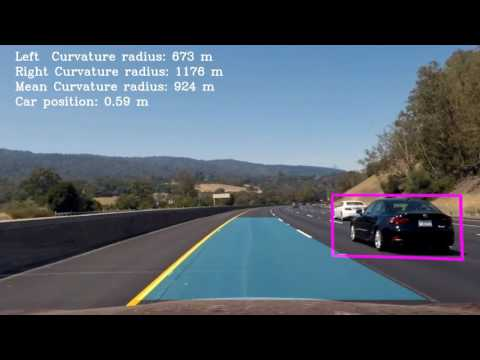

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('S83Pg0e4Lec')

#### Discussion. Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

The main challenges were deciding the positioning, right scale and the overalp between the sliding window patches to achieve a balance between reducing false positive, reducing processing time and 100% vehicle detection. Another issue was setting the right depth of history to smoothen the heatmap across frames as well as strip out false positives. One of the false positive filters used is dependent on a minimum area. This could prove to be an issue with smaller profile vehicles such as a motor bike. The pipline seems to work satifactorily in different lighting and shadow conditions but I suspect that this needs further testing. 

One area that definitiely needs improvement is the time taken to process a frame which is currently 0.5 secs. This is obviously too slow for real time conditions which would need atleast a fact of 2 or 3 times improvement. One possibility is not calculating the ho g features for every patch. Rather, we could calculate the hog features for the entire image and then slice the hog features array based on the patch coordinates. I have started to explore this (code commented out in the get_hot_windows search function) but needs further testing. Another optimisation would be parallelisation of feature calculation across each channel as well as exploring a cnn based classifier. I have also not used the additional vehicle dataset recently release by udacity but hope to use it for augmenting the training data and re-run the pipeline.
